# Fraud detection of account addresses on Ethereum blockchain

## Data Visualization

### Imports

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import random
import seaborn as sns
import torch

from utils import *

### Load

In [2]:
SEED = 104
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

df = pd.read_csv('data/eth_illicit_features.csv')

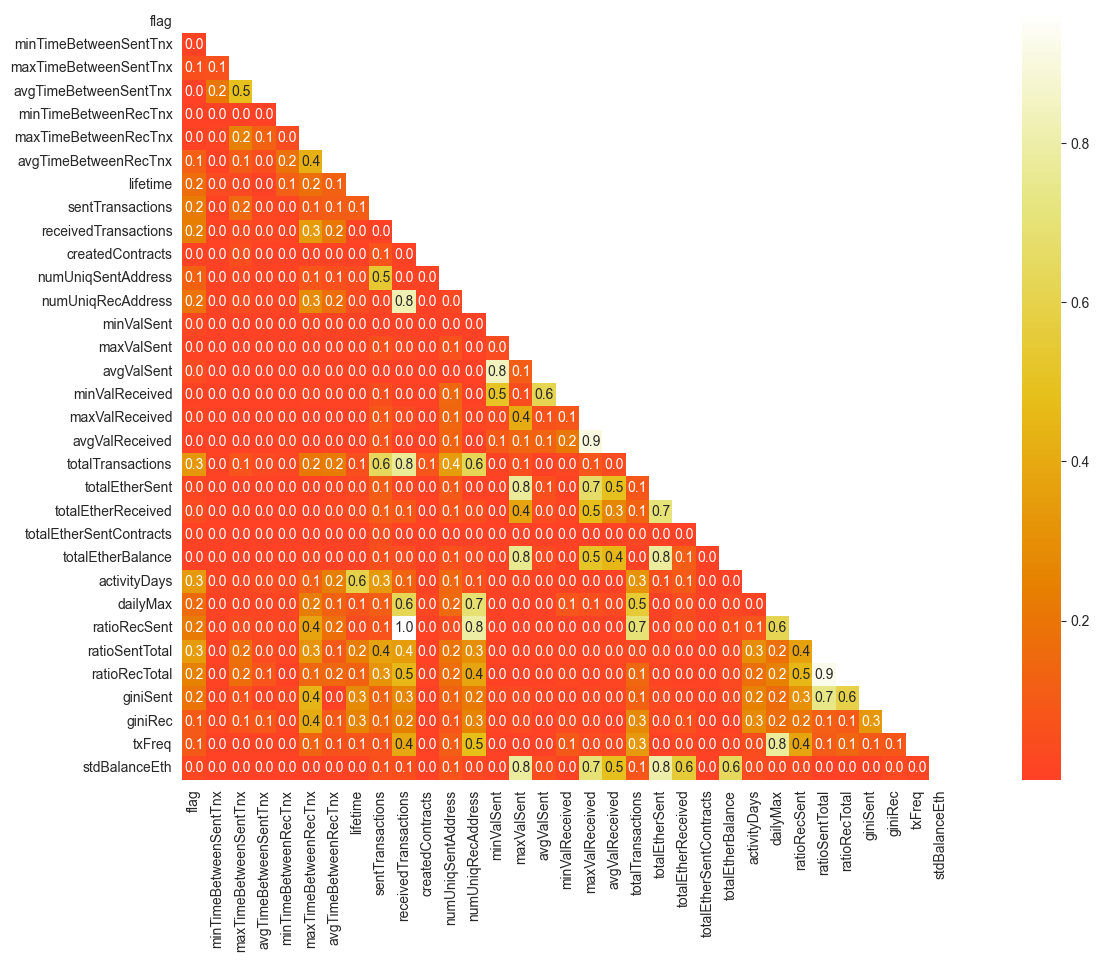

In [3]:
df_feat = df.iloc[:, 1:]
corr = df_feat.corr().abs()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18, 10))
    sns.heatmap(corr, mask=mask, annot=True, cmap='CMRmap', center=0, square=True, fmt='.1f')

Some features are highly correlated and we can drop either ones with lower correlation with flag (target).

In [4]:
corr_th = 0.9
pairs = find_highly_correlated(corr.iloc[1:, 1:], threshold=corr_th)
must_delete = find_least_correlated_with(pairs, corr, 'flag')
df_feat.drop(must_delete, axis=1, inplace=True)

Dataset might not be balanced (positive and negative cases), hence we resample negative cases randomly to match the number of positive cases.

In [5]:
pos_samples = df_feat[df_feat.flag == 1]
neg_samples = df_feat[df_feat.flag == 0].sample(len(pos_samples), random_state=SEED)
data = pd.concat([pos_samples, neg_samples], axis=0)
X = data.iloc[:, 1:]
y = data.flag

Then, we also replace any `NaN` value in `X` with average of its column.

In [6]:
for key in X.columns:
    X[key] = X[key].fillna(X[key].mean())

## Dataset Preparation

### Imports

In [7]:
from dataset import ETHDataset, Compose, ToTensor, Normalize
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader

### Normalization

We normalize features by removing the average and scaling to unit variance.

In [8]:
mean = X.mean(axis=0).values
std = X.std(axis=0).values
transform = Compose([
    ToTensor(),
    Normalize(mean=tuple(mean), std=tuple(std)),
])

### Cross-validation

We use `k`-folds cross-validation, i.e., split dataset to `k` random folds and each fold will be used exactly once as a validation set while remaining `k-1` folds are used as training set.

In [9]:
k = 10
kf = KFold(n_splits=k, shuffle=True, random_state=SEED)

## Training

### Imports

In [10]:
from pycm import ConfusionMatrix
from tensorboardX import SummaryWriter
import torch.nn as nn
import tqdm

from network import FCN

### Pytorch initialization

We use SGD optimizer with initial learning rate `lr=0.1`, momentum of `0.9`, and decay rate of `1e-4`. To avoid sticking to local optimum points, we decrease the learning rate by `10` folds at epochs 30, 60, 90. Furthermore, we use linear warmup from `1e-3` to initial `lr` over 5 epochs.

In [11]:
iterations = 12000
bs = 100
epochs = iterations // (len(X) * (k - 1) // k // bs)
criterion = nn.CrossEntropyLoss()
writer = SummaryWriter('results')

### Training

In [12]:
best_cm = None
worst_cm = None
cm_list = []
for i, (train_idx, val_idx) in enumerate(kf.split(X)):
    model = FCN(len(X.columns), 2)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-4)
    sch1 = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1e-2, end_factor=1, total_iters=5)
    sch2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, [30, 60, 80], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.ChainedScheduler(schedulers=[sch1, sch2])
    data_train, data_val = data.iloc[train_idx], data.iloc[val_idx]
    data_train = ETHDataset(data_train, transform, 'flag')
    data_val = ETHDataset(data_val, transform, 'flag')
    train_loader = DataLoader(data_train, batch_size=bs, shuffle=True, pin_memory=True, drop_last=True)
    val_loader = DataLoader(data_val, batch_size=1, shuffle=False, pin_memory=False, drop_last=False)
    title = f'Training on {ordinal(i + 1)} fold'
    progress = tqdm.tqdm(range(epochs), ncols=150, smoothing=0.9, leave=True, miniters=1, desc=title)
    for j in progress:
        train_loss = AverageMeter()
        model.train()
        for k, (x, target) in enumerate(train_loader):
            pred = model(x)
            loss = criterion(pred, target)
            optimizer.zero_grad(set_to_none=True)
            loss.backward()
            optimizer.step()
            train_loss.update(loss.item(), count=x.shape[0])
        scheduler.step()
        val_loss = AverageMeter()
        val_acc = AverageMeter()
        model.eval()
        for k, (x, target) in enumerate(val_loader):
            pred = model(x)
            loss = criterion(pred, target)
            val_loss.update(loss.item(), count=x.shape[0])
            pred = pred.max(1)[1]
            val_acc.update(torch.mean(torch.eq(pred, target) * 1.))
        writer.add_scalars(f'fold-{i + 1}', {'lr': scheduler.get_last_lr(), 'train-loss': train_loss.average, 'val-loss': val_loss.average, 'val-acc': val_acc.average}, global_step=j + 1)
    val_pred = []
    val_target = []
    for k, (x, target) in enumerate(val_loader):
        pred = model(x)
        val_pred.append(pred.max(1)[1])
        val_target.append(target)
    val_pred = torch.cat(val_pred, dim=0).squeeze().numpy()
    val_target = torch.cat(val_target, dim=0).squeeze().numpy()
    val_cm = ConfusionMatrix(actual_vector=val_target, predict_vector=val_pred)
    val_cm.relabel({0: 'Non-fraud', 1: 'Fraud'})
    cm_list.append(val_cm)
    if best_cm is None:
        best_cm = val_cm
        worst_cm = val_cm
    else:
        if val_cm.Overall_ACC > best_cm.Overall_ACC:
            best_cm = val_cm
        elif val_cm.Overall_ACC < worst_cm.Overall_ACC:
            worst_cm = val_cm
    progress.close()
writer.close()

Training on 10th fold: 100%|████████████████████████████████████████████████████████████████████████████████████████| 130/130 [03:14<00:00,  1.49s/it]


### Performance

accuracy:  0.92
F1:  0.92
precision:  0.91
recall:  0.95


<AxesSubplot: title={'center': 'Best Fold'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

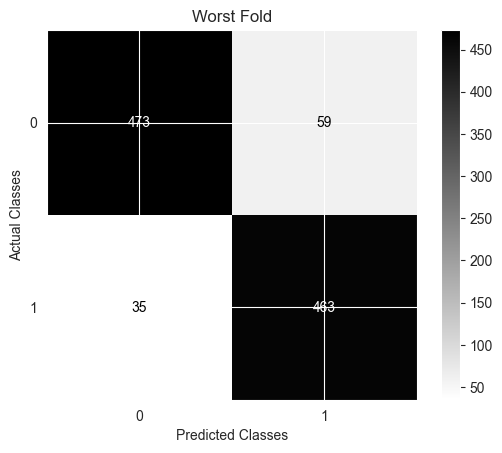

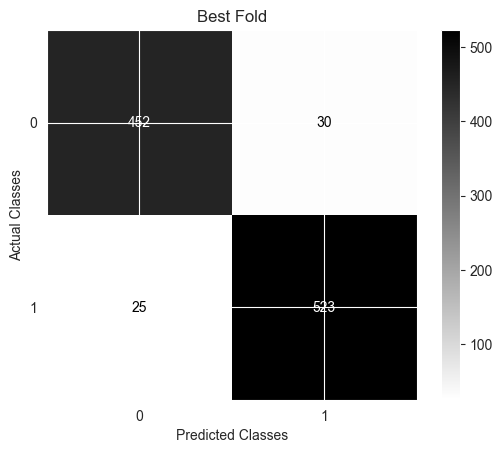

In [13]:
temp = {'accuracy': [], 'F1': [], 'precision': [], 'recall': []}
for cm in cm_list:
    temp['accuracy'].append(cm.Overall_ACC)
    temp['F1'].append(cm.F1[1])
    temp['precision'].append(cm.PPV[1])
    temp['recall'].append(cm.TPR[1])
for k in temp.keys():
    print(f'{k}: {np.mean(temp[k]): .2f}')
worst_cm.plot(title='Worst Fold', number_label=True)
best_cm.plot(title='Best Fold', number_label=True)